In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,SimpleRNN,Flatten
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Omar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Omar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import chardet
with open('training.1600000.processed.noemoticon.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [11]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [12]:
data.columns = ['target','id','date','flag','user','content']

In [13]:
data.head()

,target,id,date,flag,user,content
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [14]:
print('{} rows and {} cloumns'.format(data.shape[0],data.shape[1]))

1599999 rows and 6 cloumns


**Class Distribution**

Text(0,0.5,'samples')

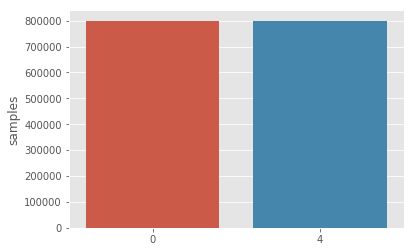

In [15]:
x = data.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

**EDA of Tweets**

*Number of characters in a tweet*

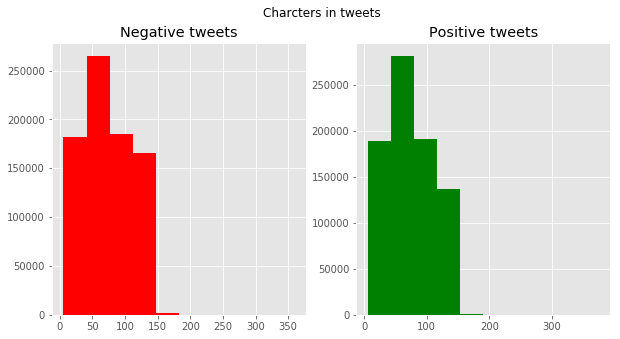

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = data[data['target'] == 0]['content'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Negative tweets')
tweet_len = data[data['target'] == 4]['content'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Positive tweets')
fig.suptitle('Charcters in tweets')
plt.show()

*Numbers of words in a tweet*

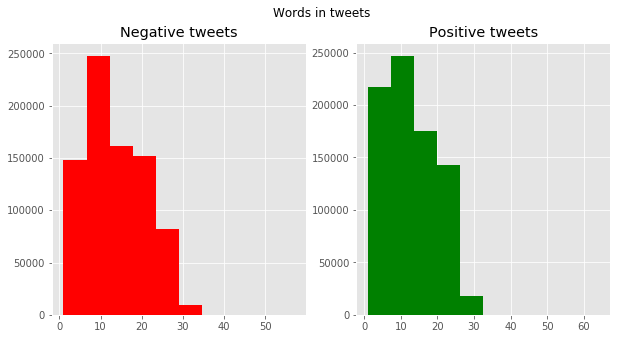

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = data[data['target'] == 0]['content'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Negative tweets')
tweet_len = data[data['target'] == 4]['content'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Positive tweets')
fig.suptitle('Words in tweets')
plt.show()

***Create Corpus***

In [18]:
def create_corpus(target):
    corpus = []
    for x in data[data['target']==target]['content'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

**Common stopwords in tweets**

*Analyze Negative tweets*

In [19]:
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<Container object of 10 artists>

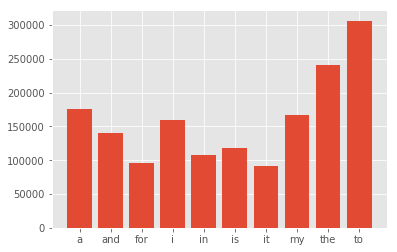

In [20]:
x,y=zip(*top)
plt.bar(x,y)

*Analyze positive tweets*

<Container object of 10 artists>

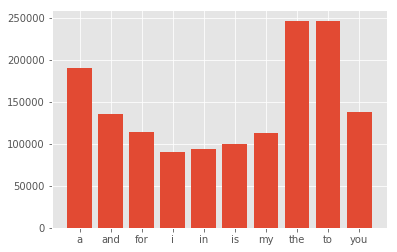

In [21]:
corpus = create_corpus(4)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

**Common Words**

*for positive tweets*

In [22]:
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

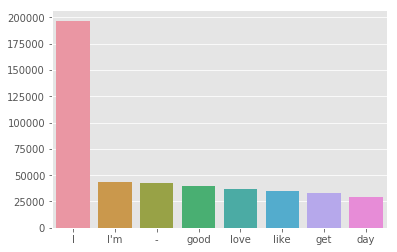

In [23]:
sns.barplot(x=x,y=y)

*for negative tweets*

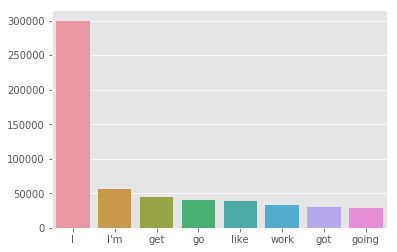

In [24]:
corpus = create_corpus(0)
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=x,y=y)

In [25]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

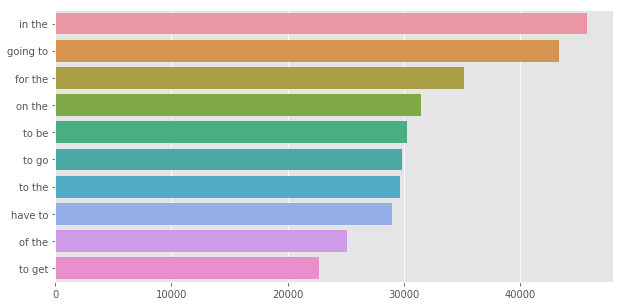

In [26]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(data['content'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

**Data Cleaning**

*Removing URLs*

In [27]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

data['content'] = data['content'].apply(lambda x: remove_URL(x))

*Removing HTML tags*

In [28]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

data['content'] = data['content'].apply(lambda x: remove_html(x))

*Romoving Emojis*

In [29]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['content'] = data['content'].apply(lambda x: remove_emoji(x))

*Removing punctuations*

In [30]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

data['content'] = data['content'].apply(lambda x: remove_punct(x))

In [31]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['content']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [34]:
corpus=create_corpus(data)

100%|██████████████████████████████████████████████████████████████████████| 1599999/1599999 [04:21<00:00, 6117.07it/s]


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
x = tokenizer.texts_to_sequences(corpus)
x_padded = pad_sequences(x,maxlen=50,truncating='post',padding='post')
y = data['target']


In [45]:
y = np.asarray(y)

In [65]:
y = np.where(y==4,1,y)

In [73]:
x_padded.shape

(1599999, 50)

In [67]:
y.shape

(1599999,)

**Number of Unique words**

In [42]:
word_index = tokenizer.word_index
print(len(word_index))

690389


In [48]:
num_words = len(word_index) + 1

**Shuffling Data and Splitting it**

In [70]:
indices = np.arange(x_padded.shape[0])
np.random.shuffle(indices)
data = x_padded[indices]
labels = y[indices]

In [71]:
x_train = data[:1000000]
y_train = labels[:1000000]
x_val = data[1000000: 1599999]
y_val = labels[1000000: 1599999]

In [72]:
model = Sequential()
model.add(Embedding(num_words,8,input_length=50))
model.add(Flatten())
#model.add(SimpleRNN(32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 8)             5523120   
_________________________________________________________________
flatten_8 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 401       
Total params: 5,523,521
Trainable params: 5,523,521
Non-trainable params: 0
_________________________________________________________________
Train on 1000000 samples, validate on 599999 samples
Epoch 1/10
1000000/1000000 [==============================] - 449s 449us/step - loss: 0.5005 - acc: 0.7634 - val_loss: 0.4767 - val_acc: 0.7805
Epoch 2/10
1000000/1000000 [==============================] - 443s 443us/step - loss: 0.4694 - acc: 0.7860 - val_loss: 0.4743 - val_acc: 0.7812
Epoch 3/10
1000000/1000000 [====

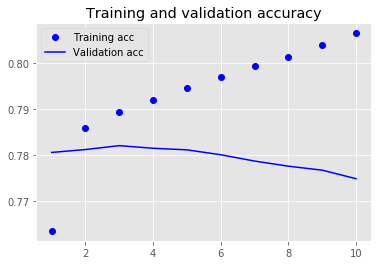

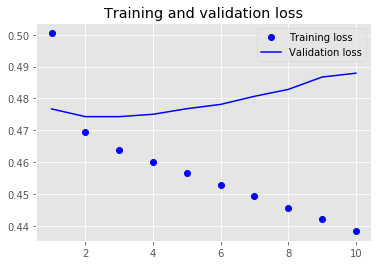

In [74]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()